## **Perfil Consumidor - CETAX Consultoria**

### Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from fbprophet import Prophet
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import googlemaps
import time
import pickle
import seaborn as sns
from IPython.display import HTML

###  Função distance
Função para acessar o API do Google MAPS e retirar a distância em metros entre dois endereços distintos.

In [2]:
#gmaps = googlemaps.Client(key='DIGITE A SUA KEY')
def distance(origem, destino):  
    """Function that calculates the distance between origen and destino
    Parameters:
    -----------
    Inputs:
        origem (str): 
        destino (str):
    Return:
        distance (float): distance between origem and destino, given by the maps API
    """
    distance_result = gmaps.distance_matrix(origins=origem,
                                        destinations=destino,
                                        mode='walking', units='metric')
    if (distance_result['rows'][0]['elements'][0]['status'] == 'NOT_FOUND'):
        return 0
    else:
        return distance_result['rows'][0]['elements'][0]['distance']['value']

### Pre-Processing the Dataset
<p align="justify">Tratamento inicial do dataset, onde será retirado dados de clientes duplicados, calcular a idade dos clientes a partir da data de nascimento, retirar variáveis que possuem mais de 50% dos dados incompletos(NaN), variáveis de data e também variáveis que possuem o mesmo valor para mais de 75% dos dados.</p>

In [3]:
dataset = pd.read_excel('regs.xlsx') # Importando o dataset

dataset.drop_duplicates(subset='SKASSOCIADO', inplace=True) # Retirando dados duplicados


# Tratando idade a partir da data de nascimento
idade = pd.DataFrame()
idade['Data'] = dataset.DTNASCTL
idade['Ano'] = idade.Data.replace('.*/.*/(.*)', value=r'\1', regex=True).astype(int)
idade['Idade'] = 117 - idade.Ano

# Retirando variáveis com mais de 50% dos dados incompletos
for var in dataset:
    if(dataset[var].isnull().sum() + len(dataset[var].loc[dataset[var].astype(str) == ' ']) > 3000):
        dataset.drop(var, axis=1, inplace=True)


# Retirando variaveis onde mais de 75% dos dados possuem mesmo valor
for var in dataset:
    for i in dataset[var].value_counts():
        if(i>4500):
            dataset.drop(var, axis=1, inplace=True)
    
# Retirando variáveis de data
for var in dataset:
    if (re.match('SKDT', var)):
        dataset.drop(var, axis=1, inplace=True)
    elif (re.match('DT', var)):
        dataset.drop(var, axis=1, inplace=True)
        

### **Feature Extraction**
Retirando do dataset as features que serão utilizadas na clusterização.

In [4]:
# Criando dataframe com as features que serão utilizadas
dtrain = pd.DataFrame()
dtrain['END_Cliente'] = dataset.NRENDERE.astype(str) + ', ' + dataset.DSENDERE + ', ' + dataset.NMBAIRRO_2+ ', ' + dataset.NMCIDADE_2
dtrain['END_Agencia'] = dataset.NRENDCOP.astype(str) + ', ' + dataset.DSENDCOP + ', ' + dataset.NMBAIRRO+ ', ' + dataset.NMCIDADE
dtrain['Seguro'] = dataset.DSSEGURO
dtrain['ValorSEG'] = dataset.VLPRESEG
dtrain['Renda'] = dataset.VL_RENDA_FATANUAL
dtrain['Idade'] = idade.Idade
dtrain['GrupoRenda'] = dataset.DSGRUPORENDAFAT
dtrain['Sexo'] = dataset.DSSEXO


# Tratamento da distância entre o endereço do cliente e da agência em que abriu o seguro

''' USO DO API DO GOOGLE MAPS PARA PEGAR A DISTANCIA ENTRE OS ENDEREÇOS,
    APÓS A PRIMEIRA EXTRAÇÃO, OS DADOS FORAM GRAVADOS EM UM ARQUIVO PICKLE PARA EVITAR REALIZAR AS MESMAS
    REQUISIÇÕES NO API NOVAMENTE
    
dtrain['Distancia'] = np.ones((5390,1))
for i in dtrain.index:
    dtrain['Distancia'][d[i]] = distance(origem=dtrain['END_Cliente'][d[i]],destino=dtrain['END_Agencia'][d[i]])

output = open('distancia.pickle', 'wb')
pickle.dump(dtrain['Distancia'], output)
output.close()

dtrain.Distancia.loc[dtrain.Distancia == 0] = np.NaN
dtrain.Distancia = dtrain.Distancia.fillna(dtrain.Distancia.mean())
'''
f = open('distancia.pickle', 'rb')
dtrain['Distancia'] = pickle.load(f)
f.close()
dtrain.Distancia = dtrain.Distancia / 1000

# Mapeando renda por grupo
# renda = dtrain.GrupoRenda.value_counts()
# for i in range(2,7):
#     renda[i-2] = i
# renda[5] = 1
# renda[6] = 7
# renda[7] = 0
# dtrain.GrupoRenda = dtrain.GrupoRenda.map(renda)

def age_group(idade):
    """Função que agrupa a idade em grupos
    Parameters:
    -----------
    Inputs:
        idade (int):
    Return:
        group (str): grupo em que a idade pertence
    """
    if idade<30:
        return 'Entre 18 e 30 anos' # grupo 0, idade menor que 30 anos
    elif idade<45:
        return 'Entre 30 e 45 anos' # grupo 1, idade entre 30 e 45 anos
    elif idade<60:
        return 'Entre 45 e 60 anos' # grupo 2, idade entre 45 e 60 anos
    elif idade<80:
        return 'Entre 60 e 80 anos' # grupo 3, idade entre 60 e 80 anos
    else:
        return 'Acima de 80 anos'# grupo 4, idade maior que 80 anos

def valor_group(valor):
    """Função que agrupa o valor do seguro em grupos
    Parameters:
    -----------
    Inputs:
        idade (int):
    Return:
        group (str): grupo em que o valor pertence
    """
    if valor<425:
        return 'Entre 300,00 reais e 425,00 reais'
    elif valor<550:
        return 'Entre 425,00 reais e 550,00 reais'
    elif valor<675:
        return 'Entre 550,00 reais e 675,00 reais'
    elif valor<800:
        return 'Entre 675,00 reais e 800,00 reais'
    else:
        return 'Acima de 800,00 reais'

# Mapeando idade por grupo
dtrain['GrupoIdade'] = dtrain.Idade
dtrain.GrupoIdade = dtrain.GrupoIdade.apply(age_group)

def dist_group(distancia):
    """Função que agrupa a distância em grupos
    Parameters:
    -----------
    Inputs:
        distancia (int): distancia dada em quilometros
    Return:
        group (str): grupo em que a distância pertence
    """
    if distancia<25:
        return 'Menos de 25 km'
    elif distancia<50:
        return 'Entre 25 e 50 km'
    elif distancia<75:
        return 'Entre 50 e 75 km'
    elif distancia<100:
        return 'Entre 75 e 100 km'
    else:
        return 'Acima de 100 km'
# Mapeando distância por grupo
dtrain['GrupoDistancia'] = dtrain.Distancia
dtrain.GrupoDistancia = dtrain.GrupoDistancia.apply(dist_group)

# Pegando as variáveis finais para clusterizar
dfinal = dtrain[['Seguro','ValorSEG','Renda','Idade','Distancia','Sexo','GrupoRenda']]

In [5]:
dfinal.head(10)

,Seguro,ValorSEG,Renda,Idade,Distancia,Sexo,GrupoRenda
0,CASA,31.22,3394.49,49,5.600,Masculino,De 3 a 5 Salários Mínimos
1,CASA,24.38,6409.31,74,5.716,Masculino,De 5 a 10 Salários Mínimos
2,VIDA,9.56,3566.85,25,2.155,Masculino,De 3 a 5 Salários Mínimos
4,VIDA,33.14,4370.26,41,56.656,Feminino,De 3 a 5 Salários Mínimos
5,CASA,14.31,4000.00,54,54.868,Masculino,De 3 a 5 Salários Mínimos
6,CASA,32.45,22000.00,44,6.226,Feminino,Acima de 20 Salários Mínimos
7,PRESTAMISTA,0.00,6320.00,31,5.312,Masculino,De 5 a 10 Salários Mínimos
8,VIDA,21.25,5741.40,49,3.865,Masculino,De 5 a 10 Salários Mínimos
9,CASA,3.91,1722.75,58,11.341,Masculino,De 1 a 2 Salários Mínimos
10,CASA,24.65,1700.00,20,17.920,Masculino,De 1 a 2 Salários Mínimos


In [6]:
lista = list(dfinal.groupby('Seguro'))
train_casa = lista[0][1]
train_casa = train_casa.drop([1764, 2084,474, 1239, 3158, 3277, 4110, 4362, 5125, 5285, 5312])
train_casa.drop('Seguro', axis=1, inplace=True)
sexo_casa = train_casa.Sexo
sexo_casa = pd.DataFrame(data=sexo_casa)
sexo_casa = sexo_casa.reset_index()
renda_casa = train_casa.GrupoRenda
renda_casa = pd.DataFrame(data=renda_casa)
renda_casa = renda_casa.reset_index()
train_casa.drop('Sexo', axis=1, inplace=True)
train_casa.drop('GrupoRenda', axis=1, inplace=True)
train_presta = lista[1][1]
train_presta.drop('Seguro', axis=1, inplace=True)
train_presta.drop('Sexo', axis=1, inplace=True)
train_presta.drop('GrupoRenda', axis=1, inplace=True)
train_vida = lista[2][1]
sexo_vida = train_vida.Sexo
sexo_vida = pd.DataFrame(data=sexo_vida)
sexo_vida = sexo_vida.reset_index()
renda_vida = train_vida.GrupoRenda
renda_vida = pd.DataFrame(data=renda_vida)
renda_vida = renda_vida.reset_index()
train_vida.drop('Sexo', axis=1, inplace=True)
train_vida.drop('GrupoRenda', axis=1, inplace=True)
train_vida.drop('Seguro', axis=1, inplace=True)

In [7]:
train_casa.head(10)

,ValorSEG,Renda,Idade,Distancia
0,31.22,3394.49,49,5.600000
1,24.38,6409.31,74,5.716000
5,14.31,4000.00,54,54.868000
6,32.45,22000.00,44,6.226000
9,3.91,1722.75,58,11.341000
10,24.65,1700.00,20,17.920000
11,14.31,2520.08,40,31.679774
12,22.33,1535.26,42,31.679774
13,32.45,18000.00,39,41.712000
14,27.08,3350.00,48,12.531000


In [8]:
#train_casa = train_casa.drop([1764, 2084,474, 1239, 3158, 3277, 4110, 4362, 5125, 5285, 5312])

### Separando os dados por tipo de seguro
Será retirado os dados pelo tipo de seguro de cada cliente, de modo a traçar os perfis dos consumidores de seguro de casa e dos de seguro de vida (prestamistas não pagam seguro, não havendo interesse nesse caso).

### Clustering via K-Means
Fase de clusterização, no qual os dados serão normalizados e depois será utilizado o algoritmo do K-Means para a clusterização.

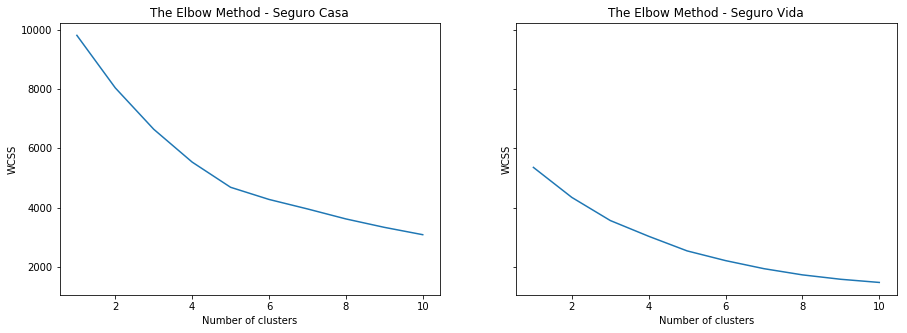

In [9]:
# Normalizando os dados
sc_casa = StandardScaler().fit(train_casa)
train_casa = sc_casa.transform(train_casa)
sc_vida = StandardScaler().fit(train_vida)
train_vida = sc_vida.transform(train_vida)


'''Using the elbow method to find graphically the optimal number of clusters
    Parameters:
        wcss (float): Sum of squared distances of samples to their closest cluster center.
        n_clusters (int): number of clusters
'''

# Subplot para o seguro de casa:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True)
wcss_casa = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(train_casa)
    wcss_casa.append(kmeans.inertia_)
ax1.plot(range(1, 11), wcss_casa)
ax1.set_title('The Elbow Method - Seguro Casa')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')

# Subplot para o seguro de Vida:
wcss_vida = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(train_vida)
    wcss_vida.append(kmeans.inertia_)
ax2.plot(range(1, 11), wcss_vida)
ax2.set_title('The Elbow Method - Seguro Vida')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('WCSS')
plt.show()

### Seguro de casa:

In [10]:
# Fitting K-Means to the dataset
# Seguro de casa:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
resultado = kmeans.fit_predict(train_casa)
grupos = pd.DataFrame(data=resultado, columns = {'Grupo': '0'})
#sexo_casa = pd.DataFrame(data=sexo_casa, columns = {'Sexo': '0'})
train_casa = sc_casa.inverse_transform(train_casa)
train_casa = pd.DataFrame(data=train_casa, columns=list(train_presta.columns))
train_casa = train_casa.join(grupos)
train_casa['Sexo'] = sexo_casa['Sexo']
train_casa['GrupoRenda'] = renda_casa['GrupoRenda']
train_casa.Idade = train_casa.Idade.astype(int)
train_casa.ValorSEG = train_casa.ValorSEG * 12

print('Correlação das variáveis:\n',train_casa.corr().Grupo,'\n')
print('Total de pessoas por grupo:\n',train_casa.Grupo.value_counts(),'\n')
print('Valores médios por grupo:\n',train_casa.groupby('Grupo').mean(),'\n')
print('Valores medianos por grupo:\n',train_casa.groupby('Grupo').median(),'\n')
print('Erro de desvio por grupo:\n',train_casa.groupby('Grupo').std(),'\n')
# perfil_casa_medio = train_casa.groupby('Grupo').mean()
# total_casa = train_casa.Grupo.value_counts()
# perfil_casa_medio['TotalSEG'] = total_casa
# perfil_casa_medio['Valor_Total'] = perfil_casa_medio['TotalSEG'] * perfil_casa_medio['ValorSEG']
# perfil_casa_erro = train_casa.groupby('Grupo').std()

Correlação das variáveis:
 ValorSEG    -0.420417
Renda       -0.069512
Idade       -0.520441
Distancia    0.231797
Grupo        1.000000
Name: Grupo, dtype: float64 

Total de pessoas por grupo:
 4    798
1    776
0    477
3    346
2     55
Name: Grupo, dtype: int64 

Valores médios por grupo:
          ValorSEG         Renda      Idade  Distancia
Grupo                                                
0      540.022138   3770.538470  46.893082  21.757419
1      196.885361   2917.820825  59.485825  16.547210
2      412.245818  21402.717455  48.436364  22.609016
3      251.789480   3249.220780  48.554913  58.771540
4      217.677293   2810.953947  35.916040  22.783674 

Valores medianos por grupo:
        ValorSEG      Renda  Idade  Distancia
Grupo                                       
0        494.52   3005.000     47    20.4410
1        172.32   2364.880     58    12.5550
2        389.40  18556.000     46    14.6020
3        267.96   2500.000     48    56.8845
4        222.48   2224.09

#### Grupo 0 - Alto valor de seguro

In [11]:
casa_0 = train_casa[['Renda','Idade','ValorSEG','Distancia','Sexo','GrupoRenda']].loc[train_casa.Grupo==0]
casa_0['GrupoIdade'] = casa_0.Idade
casa_0.GrupoIdade = casa_0.GrupoIdade.apply(age_group)
casa_0['GrupoDist'] = casa_0.Distancia
casa_0.GrupoDist = casa_0.GrupoDist.apply(dist_group)
casa_0['GrupoValor'] = casa_0.ValorSEG
casa_0.GrupoValor = casa_0.GrupoValor.apply(valor_group)
print('Total de pessoas: ', casa_0.shape[0])
print('Total de faturamento: R$%.2f' % (casa_0.ValorSEG.sum()))

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')

Total de pessoas:  477
Total de faturamento: R$257590.56


Relação de renda:


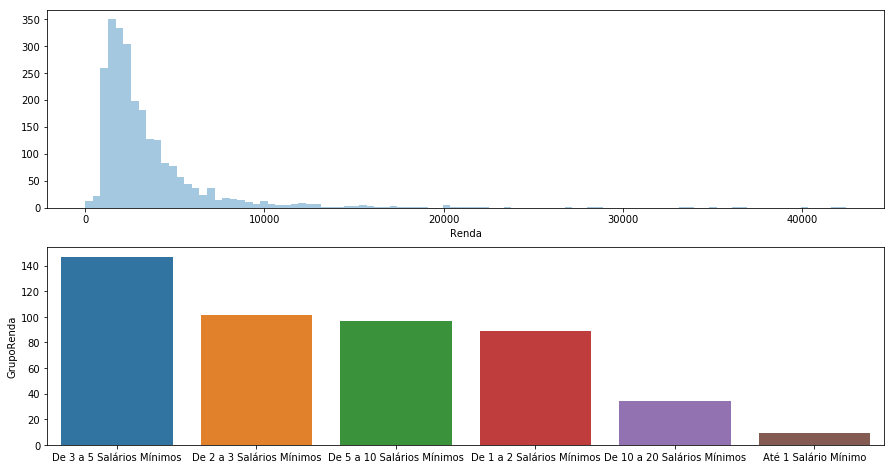

A renda do grupo varia entre 1 e 6 salários mínimos, sendo a maior
parte concentrada em torno de R$3005.00 (3 salários mínimos).


In [12]:
print('Relação de renda:')
fig, [ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(15, 8)
sns.barplot(pd.DataFrame(casa_0.GrupoRenda.value_counts()).index.values,casa_0.GrupoRenda.value_counts(),ax=ax2)
sns.distplot(train_casa.Renda, kde=False, rug=False, bins = 100,ax=ax1)
plt.show()
print('A renda do grupo varia entre %d e %d salários mínimos, sendo a maior' % ((casa_0.Renda.mean()-casa_0.Renda.std())/937,(casa_0.Renda.mean()+casa_0.Renda.std())/937))
print('parte concentrada em torno de R$%.2f (%d salários mínimos).' % (casa_0.Renda.median(),casa_0.Renda.median()/937))

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')


Relação da Idade:


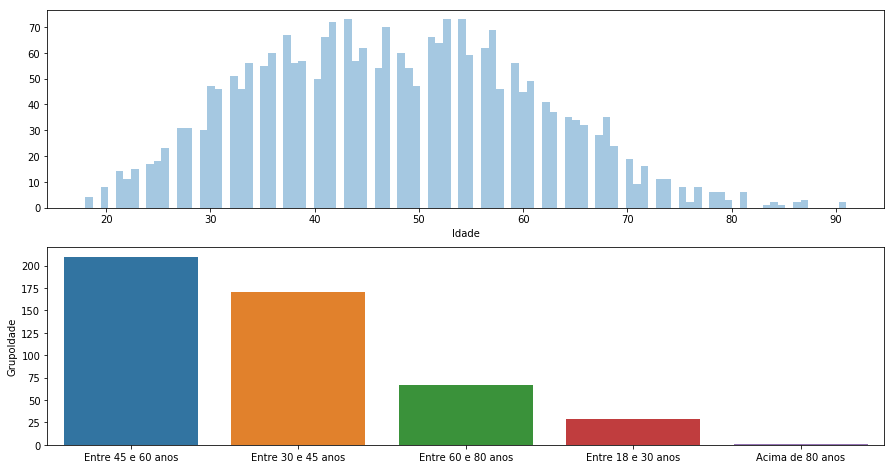

A idade do grupo varia entre 36 e 57, sendo a maior
parte concentrada em torno de 47 anos.


In [13]:
print('\nRelação da Idade:')
fig, [ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(15, 8)
sns.barplot(pd.DataFrame(casa_0.GrupoIdade.value_counts()).index.values,casa_0.GrupoIdade.value_counts(),ax=ax2)
sns.distplot(train_casa.Idade, kde=False, rug=False, bins = 100,ax=ax1)
plt.show()
print('A idade do grupo varia entre %d e %d, sendo a maior' % ((casa_0.Idade.mean()-casa_0.Idade.std()),(casa_0.Idade.mean()+casa_0.Idade.std())))
print('parte concentrada em torno de %d anos.' % (casa_0.Idade.median()))

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')


Relação da Distância:


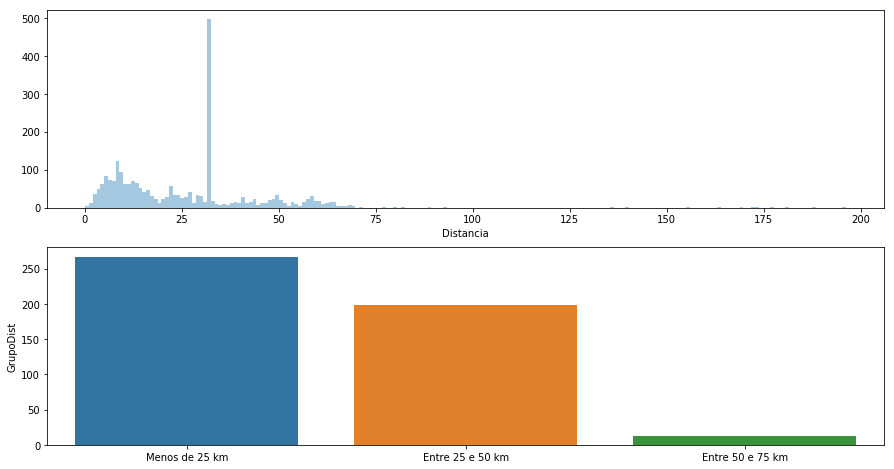

A distância entre a agência e o endereço do grupo varia entre 8.40 e 35.12 quilometros, sendo a maior
parte concentrada em torno de 31.68 km.


In [14]:
print('\nRelação da Distância:')
fig, [ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(15, 8)
sns.barplot(pd.DataFrame(casa_0.GrupoDist.value_counts()).index.values,casa_0.GrupoDist.value_counts(),ax=ax2)
sns.distplot(train_casa.Distancia, kde=False, rug=False, bins = 200, ax=ax1)
plt.show()
print('A distância entre a agência e o endereço do grupo varia entre %.2f e %.2f quilometros, sendo a maior' % ((casa_0.Distancia.mean()-casa_0.Distancia.std()),(casa_0.Distancia.mean()+casa_0.Distancia.std())))
print('parte concentrada em torno de %.2f km.' % (pd.DataFrame(casa_0.Distancia.value_counts()).index.values[0]))

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')


Relação do Valor de Seguro:


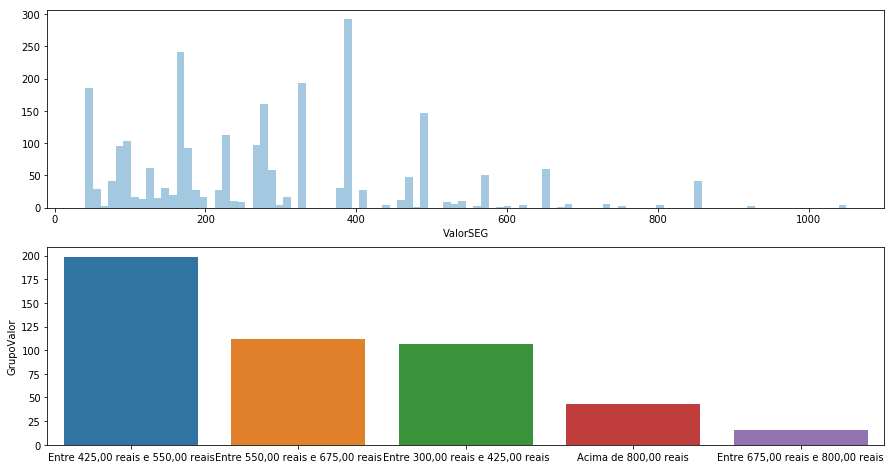

O valor de seguro do grupo gira entre R$399.96 e R$680.08, sendo a maior
parte concentrada em torno de R$494.52.


In [15]:
print('\nRelação do Valor de Seguro:')
fig, [ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(15, 8)
sns.barplot(pd.DataFrame(casa_0.GrupoValor.value_counts()).index.values,casa_0.GrupoValor.value_counts(),ax=ax2)
sns.distplot(train_casa.ValorSEG, kde=False, rug=False, bins = 100,ax=ax1)
plt.show()
print('O valor de seguro do grupo gira entre R$%.2f e R$%.2f, sendo a maior' % ((casa_0.ValorSEG.mean()-casa_0.ValorSEG.std()),(casa_0.ValorSEG.mean()+casa_0.ValorSEG.std())))
print('parte concentrada em torno de R$%.2f.' % (casa_0.ValorSEG.median()))

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')


Relação do Sexo:


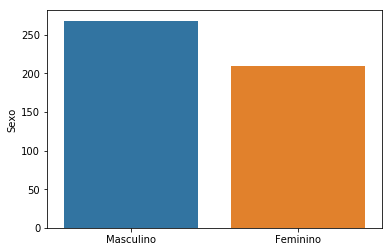

In [16]:
print('\nRelação do Sexo:')
sns.barplot(pd.DataFrame(casa_0.Sexo.value_counts()).index.values,casa_0.Sexo.value_counts())
plt.show()

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
# perfil_casa = train_casa.groupby('Grupo').mean()
# perfil_casa[['GrupoRenda','GrupoIdade','GrupoDistancia']] = train_casa.groupby('Grupo').median()[['GrupoRenda','GrupoIdade','GrupoDistancia']]
# perfil_casa['TotalSEG'] = train_casa.Grupo.value_counts()
# perfil_casa['Valor_Total'] = perfil_casa['TotalSEG'] * perfil_casa['ValorSEG']
# perfil_casa
train_casa.ValorSEG.max()

In [ ]:
pd.DataFrame(train_casa.corr())

### Seguro de vida:

In [ ]:
# Fitting K-Means to the dataset
# Seguro de vida:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
resultado = kmeans.fit_predict(train_vida)
grupos = pd.DataFrame(data=resultado, columns = {'Grupo': '0'})
train_vida = sc_vida.inverse_transform(train_vida)
train_vida = pd.DataFrame(data=train_vida, columns=list(train_presta.columns))
train_vida = train_vida.join(grupos)
#train_vida.Idade = train_vida.Idade.astype(int)

print('Correlação das variáveis:\n',train_vida.corr().Grupo,'\n')
print('Total de pessoas por grupo:\n',train_vida.Grupo.value_counts(),'\n')
print('Valores médios por grupo:\n',train_vida.groupby('Grupo').mean(),'\n')
print('Valores medianos por grupo:\n',train_vida.groupby('Grupo').median(),'\n')
print('Erro de desvio por grupo:\n',train_vida.groupby('Grupo').std(),'\n')
# perfil_vida_medio = train_vida.groupby('Grupo').mean()
# total_vida = train_vida.Grupo.value_counts()
# perfil_vida_medio['TotalSEG'] = total_vida
# perfil_vida_medio['Valor_Total'] = perfil_vida_medio['TotalSEG'] * perfil_vida_medio['ValorSEG']
# perfil_vida_erro = train_vida.groupby('Grupo').std()

In [ ]:
# perfil_vida = train_vida.groupby('Grupo').mean()
# perfil_vida[['GrupoRenda','GrupoIdade','GrupoDistancia']] = train_vida.groupby('Grupo').median()[['GrupoRenda','GrupoIdade','GrupoDistancia']]
# perfil_vida['TotalSEG'] = train_vida.Grupo.value_counts()
# perfil_vida['Valor_Total'] = perfil_vida['TotalSEG'] * perfil_vida['ValorSEG']
# perfil_vida

In [ ]:
pd.DataFrame(train_vida.corr())

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Renda','ValorSEG',data=train_casa, fit_reg=False, ax=ax)
# sns.regplot('Renda','ValorSEG',data=train_casa.loc[train_casa.Grupo==0], fit_reg=False, ax=ax, color='orange')
# sns.regplot('Renda','ValorSEG',data=train_casa.loc[train_casa.Grupo==1], fit_reg=False, ax=ax, color='blue')
# sns.regplot('Renda','ValorSEG',data=train_casa.loc[train_casa.Grupo==2], fit_reg=False, ax=ax, color='red')
# sns.regplot('Renda','ValorSEG',data=train_casa.loc[train_casa.Grupo==3], fit_reg=False, ax=ax, color='green')
# sns.regplot('Renda','ValorSEG',data=train_casa.loc[train_casa.Grupo==4], fit_reg=False, ax=ax, color='grey')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Idade','ValorSEG',data=train_casa, fit_reg=False, ax=ax)
# sns.regplot('Idade','ValorSEG',data=train_casa.loc[train_casa.Grupo==0], fit_reg=False, ax=ax, color='orange')
# sns.regplot('Idade','ValorSEG',data=train_casa.loc[train_casa.Grupo==1], fit_reg=False, ax=ax, color='blue')
# sns.regplot('Idade','ValorSEG',data=train_casa.loc[train_casa.Grupo==2], fit_reg=False, ax=ax, color='red')
# sns.regplot('Idade','ValorSEG',data=train_casa.loc[train_casa.Grupo==3], fit_reg=False, ax=ax, color='green')
# sns.regplot('Idade','ValorSEG',data=train_casa.loc[train_casa.Grupo==4], fit_reg=False, ax=ax, color='grey')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Distancia','ValorSEG',data=train_casa, fit_reg=False, ax=ax)
# sns.regplot('Distancia','ValorSEG',data=train_casa.loc[train_casa.Grupo==0], fit_reg=False, ax=ax, color='orange')
# sns.regplot('Distancia','ValorSEG',data=train_casa.loc[train_casa.Grupo==1], fit_reg=False, ax=ax, color='blue')
# sns.regplot('Distancia','ValorSEG',data=train_casa.loc[train_casa.Grupo==2], fit_reg=False, ax=ax, color='red')
# sns.regplot('Distancia','ValorSEG',data=train_casa.loc[train_casa.Grupo==3], fit_reg=False, ax=ax, color='green')
# sns.regplot('Distancia','ValorSEG',data=train_casa.loc[train_casa.Grupo==4], fit_reg=False, ax=ax, color='grey')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Renda','ValorSEG',data=train_casa.loc[train_casa.Grupo==2], fit_reg=False, ax=ax, color='red')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Renda','Idade',data=train_casa.loc[train_casa.Grupo==2], fit_reg=False, ax=ax, color='red')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Renda','Distancia',data=train_casa.loc[train_casa.Grupo==2], fit_reg=False, ax=ax, color='red')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 8)
# sns.regplot('Renda','Grupo',data=train_casa, fit_reg=False, ax=ax, color='red')
# plt.show()